In [27]:
import os
import re
import pandas as pd
import numpy
from matplotlib import pyplot as plt
import gensim
from gensim import corpora
from gensim.corpora import Dictionary
from gensim.models.tfidfmodel import TfidfModel
from gensim.models.ldamodel import LdaModel
from gensim.models import CoherenceModel
import spacy
from spacy.lang.zh import Chinese
from collections import defaultdict 
import pyLDAvis
import pyLDAvis.gensim_models

In [86]:
os.chdir('')
data_dir = './data/'
censor_data = 'censor_diary.txt'
output_dir = 'output/censordiary/'

In [87]:
articles = []
datelist = []
contents = []
with open(data_dir + censor_data,'r') as f:
    line = f.readline()
    while line:
        if re.search("Split",line):
            date = ""
            item = ""
        elif line.startswith("审查员交班日志"):
            date = re.findall(r"[0-9]{4}年.*月.*日",line)
        elif len(line) > 1:
            item = re.sub(r"^[0-9]{1,2}[\.\s．，\,]+","",line).strip()
            item = re.sub(r"https?:\/\/(www\.)?[-a-zA-Z0-9@:%._\+~#=]{1,256}\.[a-zA-Z0-9()]{1,6}\b([-a-zA-Z0-9()@:%_\+.~#?&//=]*)","[URL]",item) # URL替換
            item = re.sub(r"[a-z][a-zA-Z0-9]{8}[\s\n]{0,1}","[CODE] ",item) # 微博CODE替換
            item = re.sub(r"[a-z][a-zA-Z0-9]{8}$","[CODE] ",item) # 微博CODE替換
            datelist.extend(date)
            contents.append(item)
        line = f.readline()
        
print(datelist[:10])
print(contents[:10])
print(len(datelist),len(contents))

df = pd.DataFrame(data={'date':datelist,'content':contents})
df = df.sort_values(by=['date'])
df.head()

['2011年10月16日', '2011年10月16日', '2011年10月16日', '2011年10月16日', '2011年10月16日', '2011年10月16日', '2011年10月16日', '2011年10月16日', '2011年10月16日', '2011年10月17日']
['2000年首次公布中国部分官员财产，结果引起西方国家的羡慕、嫉妒、恨，指责中国炫富、暴富。为维护和谐的国家关系，后来中国再也不公布官员财产了', '老沉举报 见到私密处理', '高宝玉：【文革中美女们竟然就这样香消玉损】时至今日，国家为此承担了什么样的责任？看看近日上海因为拒不进行选民登记就被打死的公民，就该清楚，这个国家，实际上一切都在继续 老沉举报 见到私密处理', '[URL] 负面内容清理下，单审到明天早上7点 我先审后上了', '陈光诚事件：王小山等人去临沂，但是没有成功进入东师古村，下午有一些网友也去了，注意观察动向吧，基本都没管，网监发来的单条处理了两条。', '[URL] 网监要求删除 报老陈了同意处理，私密了', '[URL] 这条网管办让删，让新闻中心去问是谁让删的了，一直没回复，就报蒋XX了，暂时没报老大', '广西玉林军警冲突 派出所被包围 2011年10月15日晚，广西玉林发生严重军警冲突。晚上约9时，北辰派出所一名副所长带领30多名干警对驻玉林部队多名军官进行殴打，军官证全被撕烂，并强行拉到派出所继续殴打，几名军官受重伤昏迷。军官被拷打约2小时， 军方介入救人，多部军车包围北辰派出所。网管办要求清理，已请示陈彤，审核见到私密处理。', '[CODE] 陈彤要求，该内容全部删除，见到私密处理，务必要弄干净。为打击虚假信息——微博信用认证将添新“关卡”。新浪微博信用认证将加一道“关卡”，比加“V”用户的认证信息更可靠。信用较低的用户，将被限制部分功能使用。昨天，由首都文明办、市互联网信息办公室、北京网络媒体协会共同举办的创建和评选北京文明网站活动启动。年底，本市将评出首批“北京互联网文明频道”和“北京文明网站”。在现场，新浪副总裁、总编辑陈彤表示，现在，新浪正在实行加“V”用户的信息认证，这个体系的认证需要用户的真实个人信息，提高信用安全度。新浪正在筹建微博信用体系，以达到用户自律、他人监督的双重效果。同时，对低信用用户以图标形式公示，并限制

,date,content
0,2011年10月16日,2000年首次公布中国部分官员财产，结果引起西方国家的羡慕、嫉妒、恨，指责中国炫富、暴富。为...
7,2011年10月16日,广西玉林军警冲突 派出所被包围 2011年10月15日晚，广西玉林发生严重军警冲突。晚上约9...
6,2011年10月16日,[URL] 这条网管办让删，让新闻中心去问是谁让删的了，一直没回复，就报蒋XX了，暂时没报老大
5,2011年10月16日,[URL] 网监要求删除 报老陈了同意处理，私密了
8,2011年10月16日,[CODE] 陈彤要求，该内容全部删除，见到私密处理，务必要弄干净。为打击虚假信息——微博信...


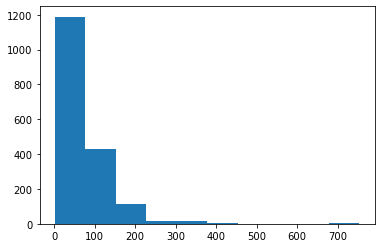

條數： 1769


In [88]:
contents_length = [len(c) for c in contents]
plt.hist(contents_length)
plt.show()
print('條數：',len(contents))

## 打標記

In [89]:
def tag(keyword,text):
    l = []
    for k in keyword:
        if re.search(k,text["content"]):
            l.append(k)
    return l

def extract_keyword(keyword,column_name,df):
    df[column_name] = df.apply (lambda row: tag(keyword,row), axis=1)
    df[column_name + "_e"] = df.apply(lambda row: 1 if len(row[column_name])>=1 else 0, axis=1)
    for k in keyword:
        df[k] = df.apply(lambda row: 1 if k in row[column_name] else 0, axis=1)

higher_order_l = ["网管办","网监"]
boss_order_l = ["老沉","陈彤","老陈"]
info_action_l = ["行动信息","行动性","煽动"]
surveillance_l = ["上报","通报"]
discussion_protect_l = ["攻击","攻击.*党","攻击.*政府","攻击.*公安","攻击.*领导人","攻击.*制度","攻击.*新浪"]
person_p_l = ["邓公","刘亚洲","曹建明","刘少奇","毛腊肉","老毛","胡表态","苏浩非","孟建柱","m建柱","孟jianzhu","mj柱","mjz","孟见诸","孙咸泽","习远平","刘利民","赵少麟","张德江","郭伯雄","习近平","郭明义","王永新","王维国","朱镕基","吕祖善","梁振英","叶选廉","王晨","苏浩","邓小平","尚福林","李长春","李源潮","戴秉国","温家宝","温","谢亚龙","陈平","邓三尺","彭丽媛","江洋潮","汪洋","李成玉","薄熙來","何家成","邹建华","周小川","老江","徐俊平","殷方龙","谷開來","袁善腊","李学明","李肇星","习总","李克强","夏德仁","薄瓜瓜","薄熙来","蔡小洪","李鸿忠","曾庆红","高勇","刘淇","谷俊山","胡德平","周斌","王军","邓商鞅","周半旗","毛新宇","王沪宁","谷開來","近平","徐才厚","盛光祖","贺国强","江三","温家","江志成","傅政华","罗清泉","高剑云","胡温习","赵洪祝","温忽悠","毛泽东","赵zi阳","王立军","鲁炜","章沁生","王岐山","周永康","唐家璇","溫總理","蔡名照","习","金一南","王勇平","赵紫阳","贾庆林","李鹏","韩正","赖昌星","刘志祥","刘金国","回良玉","习王","肖扬","黄奇帆","刘淇","郭金龙","干以胜","梁光烈","王安顺","习仲勋","叶剑英","李双江","曾其毅","刘延东","王照华","周恩来","何勇","刘源","李先念","张春贤","马凯","温总理","江澤民","刘云山","张云川","吴邦国","汪道涵","刘奇葆","胡锦涛","胡总","江泽民","温中堂","谷丽萍","李小林","杨金山","刘志军","张庆黎"]
person_y_l = ["陈光诚","许志永","胡佳","赵连海","苏雨桐","张鸣","张雪忠","薛蛮子","吴丽红","王小山","高晓松","郭伯雄","李必丰","江平","张宏良","李淑莲","江天勇","王东海","高智晟","吴祚来","北岛","孔庆东","王功权","陈可贵","王甘霖","王荔蕻","韩颖","北島","刘X波","方舟子","陈光C","余杰","郑威","吴乐宝","艾W未","柴ling","王铮","马国华","陈冲","刘霞","李wang阳","达赖","左小祖咒","罗昌平","郭玉闪","曾金燕","贺卫方","刘莎莎","刘晓波","刘xiaobo","xiaobo","李承鹏","陈克贵","张善根","刘晓原","杨凌云","浦志强","朱福祥","艾未未","杨海鹏","李庄","吕耿松","钱明奇","陈杰人","谭作人","韩寒"]
person_b_l = ["金庸","杨澜","徐明","爱玛","刘春","吴英","王思璟","张雨绮","周小平","宋英杰","李思思","汤唯","张朝阳","张泉灵","王力宏","张蓓莉","刘乐飞","杨若兮","汪小菲","李阳","张召忠","张磊","大S","周立波","马弛","茅于轼","彭少彬","曹国伟","葛优","汪峰","倪萍","李小琳","韩志国","张海迪","王惠","王宝强","吴征","查良镛","卢俊卿","郑渊洁","程青松","姜昆","杨利伟","北岛","李开复","李国庆","阿英","白岩松","王烁","柴静","铁凝","牛萌萌","周迅","张欣","卢星宇","王健林","黄健翔","郭德纲","冯骥才","朱光","王朔","杨振宁","丁磊","王巍w","马化腾","姚晨","潘石屹","王利芬","胡锡进","温云松","董文华","杨帆","李宁","章子怡","李敖","司马南","任志强","陈东升","祝咏兰","宋祖英","马云","李彦宏","赵本山","王岩","苍井空","吴法天"]
foreign_l = ["美国","日本","台湾","香港","泰国","俄罗斯","韩国","越南","菲律宾","新加坡","英国","法国","印尼"]
sina_l = ["新浪"]

extract_keyword(higher_order_l,'higher_order',df)
extract_keyword(boss_order_l,'boss_order',df)
extract_keyword(info_action_l,'info_action',df)
extract_keyword(surveillance_l,'surveillance',df)
extract_keyword(discussion_protect_l,'discussion_protect',df)

extract_keyword(person_p_l,"person_p",df)
extract_keyword(person_y_l,"person_y",df)
extract_keyword(person_b_l,"person_b",df)
extract_keyword(foreign_l,'foreign',df)
extract_keyword(sina_l,'sina',df)

In [90]:
# 找出所有人名组织名地名，筛选高官名字
nlp = spacy.load('zh_core_web_lg')

def ner(sentence):
    doc = nlp(sentence.replace('[CODE]','').replace('[URL]',''))
    person, org, gpe = set(),set(),set()
    for ent in doc.ents:
        if ent.label_ == "PERSON" and ent.text not in boss_order_l and "删" not in ent.text:
            person.update([ent.text])
        elif ent.label_ == "ORG" and ent.text not in higher_order_l:
            org.update([ent.text])
        elif ent.label_ == "GPE" and ent.text not in foreign_l:
            gpe.update([ent.text])
    return [list(person),list(org),list(gpe)]

ner_result = df.apply(lambda row: ner(row['content']), axis=1)
df['person'],df['org'],df['gpe'] = [n[0] for n in ner_result],[n[1] for n in ner_result],[n[2] for n in ner_result]

df['person_n'] = df.apply(lambda row: len(row['person']), axis=1)
df['org_n'] = df.apply(lambda row: len(row['org']), axis=1)
df['gpe_n'] = df.apply(lambda row: len(row['gpe']), axis=1)

In [91]:
# 删除数量过少的column
column_sum = list(df.sum(axis=0))
del_column = []
for i in range(len(column_sum)):
    if isinstance(column_sum[i], numpy.int64) and column_sum[i] < 20:
        del_column.append(i)
        
df = df.drop(columns=df.columns[del_column])

df.columns

Index(['date', 'content', 'higher_order', 'higher_order_e', '网管办', '网监',
       'boss_order', 'boss_order_e', '老沉', '陈彤', '老陈', 'info_action',
       'info_action_e', '行动性', '煽动', 'surveillance', 'surveillance_e', '上报',
       'discussion_protect', 'discussion_protect_e', '攻击', '攻击.*党', '攻击.*政府',
       '攻击.*领导人', '攻击.*制度', 'person_p', 'person_p_e', '习近平', '温家宝', '温', '薄熙来',
       '近平', '温家', '周永康', '习', '胡锦涛', '江泽民', 'person_y', 'person_y_e', '陈光诚',
       'person_b', 'person_b_e', 'foreign', 'foreign_e', '美国', '香港', 'sina',
       'sina_e', '新浪', 'person', 'org', 'gpe', 'person_n', 'org_n', 'gpe_n'],
      dtype='object')

In [92]:
df.head()

,date,content,higher_order,higher_order_e,网管办,网监,boss_order,boss_order_e,老沉,陈彤,...,香港,sina,sina_e,新浪,person,org,gpe,person_n,org_n,gpe_n
0,2011年10月16日,2000年首次公布中国部分官员财产，结果引起西方国家的羡慕、嫉妒、恨，指责中国炫富、暴富。为...,[],0,0,0,[],0,0,0,...,0,[],0,0,[],[],[中国],0,0,1
7,2011年10月16日,广西玉林军警冲突 派出所被包围 2011年10月15日晚，广西玉林发生严重军警冲突。晚上约9...,[网管办],1,1,0,[陈彤],1,0,1,...,0,[],0,0,[],"[北辰派出所, 玉林军警冲突 派出所]","[广西, 玉林]",0,2,2
6,2011年10月16日,[URL] 这条网管办让删，让新闻中心去问是谁让删的了，一直没回复，就报蒋XX了，暂时没报老大,[网管办],1,1,0,[],0,0,0,...,0,[],0,0,[],[],[],0,0,0
5,2011年10月16日,[URL] 网监要求删除 报老陈了同意处理，私密了,[网监],1,0,1,[老陈],1,0,0,...,0,[],0,0,[陈],[],[],1,0,0
8,2011年10月16日,[CODE] 陈彤要求，该内容全部删除，见到私密处理，务必要弄干净。为打击虚假信息——微博信...,[],0,0,0,[陈彤],1,0,1,...,0,[新浪],1,1,[],"[市互联网信息办公室, 新浪, 北京网络媒体协会, 首都文明办]",[北京],0,4,1


In [93]:
df.to_csv(output_dir+"content.csv")

In [94]:
df.corr(method='spearman').style.background_gradient(cmap='Reds')

,higher_order_e,网管办,网监,boss_order_e,老沉,陈彤,老陈,info_action_e,行动性,煽动,surveillance_e,上报,discussion_protect_e,攻击,攻击.*党,攻击.*政府,攻击.*领导人,攻击.*制度,person_p_e,习近平,温家宝,温,薄熙来,近平,温家,周永康,习,胡锦涛,江泽民,person_y_e,陈光诚,person_b_e,foreign_e,美国,香港,sina_e,新浪,person_n,org_n,gpe_n
higher_order_e,1.000000,0.704506,0.674595,0.050815,-0.045648,0.084005,0.033301,-0.012522,0.015415,-0.036814,0.073270,0.078732,-0.087077,-0.087077,-0.055623,-0.024272,-0.029347,0.014701,0.000024,-0.051520,-0.007803,-0.004831,0.002504,-0.053133,-0.009308,0.012395,-0.030852,0.001932,-0.027011,0.051796,-0.007612,-0.008401,-0.034244,0.007310,-0.039097,-0.043783,-0.043783,0.042701,0.008209,-0.011609
网管办,0.704506,1.000000,-0.023242,0.088564,-0.004032,0.095954,0.040437,-0.012183,0.016691,-0.010842,0.047379,0.051546,-0.074031,-0.074031,-0.052096,-0.042695,-0.021754,0.007763,-0.037951,-0.043220,-0.039261,-0.042679,-0.008622,-0.044256,-0.039846,0.006195,-0.058002,-0.030741,-0.029991,0.054325,-0.016187,0.020156,-0.027466,-0.004842,-0.048322,-0.005813,-0.005813,0.045319,-0.007291,-0.016524
网监,0.674595,-0.023242,1.000000,-0.010617,-0.062025,0.035223,0.001574,0.002976,0.020187,-0.041957,0.055770,0.059675,-0.047501,-0.047501,-0.024747,0.008396,-0.019518,0.010590,0.032084,-0.028460,0.028154,0.034632,0.010461,-0.029639,0.026667,0.009021,0.014620,0.033075,-0.007373,0.028151,0.004707,-0.036084,-0.022234,0.012842,-0.005810,-0.056900,-0.056900,0.018070,0.014112,0.001463
boss_order_e,0.050815,0.088564,-0.010617,1.000000,0.575824,0.678367,0.343092,-0.033744,-0.058342,-0.014542,-0.045813,-0.084786,-0.063550,-0.063550,-0.060578,-0.073185,-0.051271,-0.051626,-0.103811,-0.074024,-0.053557,-0.047667,-0.054669,-0.075678,-0.054669,-0.052801,-0.078109,-0.009185,-0.021031,0.013079,-0.031444,0.060707,-0.029897,-0.019038,-0.034776,0.108114,0.108114,-0.019134,0.012984,-0.075932
老沉,-0.045648,-0.004032,-0.062025,0.575824,1.000000,-0.034491,-0.041813,-0.016804,-0.033595,-0.005452,-0.026435,-0.036502,-0.031295,-0.031295,-0.036488,-0.039094,-0.018821,-0.029727,-0.023764,-0.051739,-0.037084,-0.016804,-0.037636,-0.052559,-0.037636,-0.030404,-0.033712,0.034221,-0.028328,-0.013343,-0.013377,0.029144,0.032486,0.014114,0.008949,0.090283,0.090283,-0.046032,0.031568,-0.041747
陈彤,0.084005,0.095954,0.035223,0.678367,-0.034491,1.000000,-0.036351,-0.023643,-0.039577,-0.010702,-0.017260,-0.061866,-0.037994,-0.037994,-0.035828,-0.049819,-0.042359,-0.035021,-0.093341,-0.039820,-0.029210,-0.051526,-0.030064,-0.041093,-0.030064,-0.035819,-0.057705,-0.034206,-0.014571,0.041612,-0.021598,0.074902,-0.040591,-0.026012,-0.041891,0.080923,0.080923,0.039430,0.023696,-0.040338
老陈,0.033301,0.040437,0.001574,0.343092,-0.041813,-0.036351,1.000000,-0.018298,-0.020017,-0.012466,-0.046092,-0.043147,-0.034002,-0.034002,-0.029319,-0.030580,-0.021423,-0.017712,-0.050556,-0.030827,-0.022095,-0.001135,-0.022425,-0.031316,-0.022425,-0.018116,-0.038017,-0.017300,0.017840,-0.016318,-0.019278,-0.013080,-0.043896,-0.025790,-0.027195,0.038968,0.038968,-0.035840,-0.025489,-0.054624
info_action_e,-0.012522,-0.012183,0.002976,-0.033744,-0.016804,-0.023643,-0.018298,1.000000,0.564470,0.889946,0.179969,0.187982,0.100939,0.100939,-0.012291,0.140481,0.009171,0.046338,-0.077682,-0.043879,-0.031451,-0.025758,0.025020,-0.044575,-0.031919,-0.025786,-0.019283,-0.024625,-0.024025,-0.002497,0.016489,-0.039231,0.029669,-0.020101,0.008679,-0.008496,-0.008496,-0.096276,-0.038832,0.112246
行动性,0.015415,0.016691,0.020187,-0.058342,-0.033595,-0.039577,-0.020017,0.564470,1.000000,0.351576,0.181789,0.196819,0.025114,0.025114,-0.023556,0.072449,0.016771,0.026637,-0.036347,-0.024769,-0.017753,-0.028492,0.047029,-0.025162,-0.018017,-0.014555,-0.010650,-0.013900,-0.013561,0.016357,0.059785,-0.034057,-0.000179,-0.020721,-0.021850,-0.026869,-0.026869,-0.046341,-0.027015,0.054113
煽动,-0.036814,-0.010842,-0.041957,-0.014542,-0.005452,-0.010702,-0.012466,0.889946,0.351576,1.000000,0.105525,0.107182,0.121129,0.121129,-0.004388,0.150214,0.016986,0.057158,-0.073343,-0.039050,-0.027989,-0.017424

In [95]:
import numpy as np
import pandas as pd
import pingouin as pg
df.rcorr(method='spearman', padjust='holm').to_csv(output_dir + "corr_spearman_holm_p.csv")
df.rcorr(method='spearman', padjust='fdr_bh').to_csv(output_dir + "corr_spearman_fdr_bh_p.csv")
df.rcorr(upper='n').to_csv(output_dir + "corr_n.csv")
df.rcorr(method='spearman').to_csv(output_dir + "corr_spearman_p.csv")

#各column的加總個數
column_sum = list(df.sum(axis=0))
for i in range(len(column_sum)):
    if isinstance(column_sum[i], numpy.int64) and column_sum[i] > 20:
        print(df.columns[i],column_sum[i])

higher_order_e 242
网管办 129
网监 119
boss_order_e 309
老沉 116
陈彤 157
老陈 43
info_action_e 85
行动性 28
煽动 68
surveillance_e 139
上报 123
discussion_protect_e 204
攻击 204
攻击.*党 59
攻击.*政府 64
攻击.*领导人 32
攻击.*制度 22
person_p_e 402
习近平 65
温家宝 34
温 85
薄熙来 35
近平 67
温家 35
周永康 23
习 97
胡锦涛 21
person_y_e 130
陈光诚 26
person_b_e 119
foreign_e 127
美国 46
香港 51
sina_e 76
新浪 76
person_n 1321
org_n 825
gpe_n 905


In [85]:
date = set(list(df.date))
print("date:",len(date))

y = [0]*4
for d in date:
    if d.startswith('2011'):
        y[0] += 1
    elif d.startswith('2012'):
        y[1] += 1
    elif d.startswith('2013'):
        y[2] += 1
    elif d.startswith('2014'):
        y[3] += 1

print(y)
print("rows:",len(df))

date: 239
[106, 91, 10, 32]
rows: 1769


## 斷詞處理

In [29]:
# 使用結巴分詞
cfg = {"segmenter": "jieba"}
nlp = Chinese.from_config({"nlp": {"tokenizer": cfg}})
nlp.tokenizer.initialize(pkuseg_model="mixed")

tokenized_docs = []
for content in contents:
    content_tokenize = nlp(content)
    content_tokenize = [t.text for t in content_tokenize if not t.is_stop and t.is_alpha]
    tokenized_docs.append(content_tokenize)

print(tokenized_docs[0][:10])

Building prefix dict from the default dictionary ...
Dumping model to file cache /var/folders/tj/8zxp_k857819vb683_bbh8kw0000gn/T/jieba.cache
Loading model cost 1.111 seconds.
Prefix dict has been built successfully.


['年', '首次', '公布', '中国', '官员', '财产', '西方', '国家', '羡慕', '嫉妒']


## BOW & TFIDF

In [30]:
# 用gensim建立BOW語料
dictionary = Dictionary(tokenized_docs)
corpus = [dictionary.doc2bow(doc) for doc in tokenized_docs]

In [31]:
wc_dict = defaultdict(int)
for doc in corpus:
    for word_id, word_count in doc:
        wc_dict[word_id] += word_count

In [32]:
# 前20大常用詞

word_count_l = sorted(wc_dict.items(), key=lambda x:x[1], reverse=True)
print([ (dictionary.get(w[0]),w[1]) for w in word_count_l[:20]])

[('内容', 998), ('私密', 942), ('用户', 440), ('相关', 374), ('删除', 352), ('见到', 346), ('微博', 287), ('说', 249), ('清理', 243), ('转发', 240), ('审核', 239), ('攻击', 224), ('新闻', 220), ('评论', 220), ('URL', 212), ('陈彤', 189), ('中国', 185), ('信息', 174), ('微博中', 172), ('事件', 171)]


In [33]:
def sort_get(tfidf_weights):
    sorted_tfidf_weights = sorted(tfidf_weights, key=lambda w: w[1], reverse=True)
    return [(dictionary.get(w[0]),w[1]) for w in sorted_tfidf_weights]

tfidf = TfidfModel(corpus)
corpus_tfidf = tfidf[corpus]
for cor in corpus_tfidf:
    sorted_tfidf_weights = sort_get(cor)
    print(sorted_tfidf_weights[:10])

[('财产', 0.32682651257627376), ('公布', 0.30711586830269316), ('中国', 0.2675154312919023), ('国家', 0.2631390103840271), ('官员', 0.2613592902646452), ('嫉妒', 0.25618479004068023), ('暴富', 0.25618479004068023), ('再也', 0.2324391715028021), ('羡慕', 0.2324391715028021), ('首次', 0.2324391715028021)]
[('举报', 0.7897689695189059), ('老沉', 0.5131484040907355), ('见到', 0.30700131626207283), ('私密', 0.13672557177620964)]
[('国家', 0.27390135114699293), ('一切都在', 0.2666627043745635), ('宝玉', 0.2666627043745635), ('实际上', 0.2666627043745635), ('时至今日', 0.2666627043745635), ('选民', 0.2666627043745635), ('香消玉损', 0.2666627043745635), ('登记', 0.2419458940777779), ('承担', 0.2274874869167198), ('拒', 0.2274874869167198)]
[('单审到', 0.5081105158734015), ('我先', 0.5081105158734015), ('早上', 0.37589401770380854), ('审后', 0.31172178105805187), ('明天', 0.3012478837472656), ('点', 0.25099057534107827), ('负面', 0.20869227830848586), ('URL', 0.15231607206015552), ('清理', 0.14743581224544597), ('内容', 0.05425954338242832)]
[('没管', 0.3392666297037

## Topic Model 主題分析

In [34]:
dictionary = Dictionary(tokenized_docs)
corpus = [dictionary.doc2bow(doc) for doc in tokenized_docs]

In [35]:
# Set training parameters.
chunksize = 200
passes = 20
iterations = 400
eval_every = None  # Don't evaluate model perplexity, takes too much time.

In [36]:
# 尋找最合適的Topic數量

best_coherence = 0
for num_topics in range(1,20):
    lda_model = LdaModel(corpus=corpus,
                         id2word=dictionary,
                         num_topics=num_topics, 
                         random_state=100,
                         update_every=1,
                         chunksize=chunksize,
                         passes=passes,
                         iterations=iterations,
                         eval_every=eval_every,
                         alpha='auto')

    # Compute Coherence Score
    coherence_model_lda = CoherenceModel(model=lda_model, texts=tokenized_docs, dictionary=dictionary, coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()
    print('\n topic num: {} Coherence Score: {} '.format(num_topics,coherence_lda))
    if num_topics >= 3 and coherence_lda >= best_coherence:
        best_coherence = coherence_lda
        best_topic_num = num_topics


 topic num: 1 Coherence Score: 0.33209000215473805 

 topic num: 2 Coherence Score: 0.3311454334017225 

 topic num: 3 Coherence Score: 0.3363582796750591 

 topic num: 4 Coherence Score: 0.33936988430656845 

 topic num: 5 Coherence Score: 0.4552075789075628 

 topic num: 6 Coherence Score: 0.3930783890887049 

 topic num: 7 Coherence Score: 0.4635265847452573 

 topic num: 8 Coherence Score: 0.4574718138084436 

 topic num: 9 Coherence Score: 0.47990798762220266 

 topic num: 10 Coherence Score: 0.4816981403218987 

 topic num: 11 Coherence Score: 0.5169905578764821 

 topic num: 12 Coherence Score: 0.49117156058227157 

 topic num: 13 Coherence Score: 0.5017550556060196 

 topic num: 14 Coherence Score: 0.4753129344824719 

 topic num: 15 Coherence Score: 0.47604519121540423 

 topic num: 16 Coherence Score: 0.4758351707867132 

 topic num: 17 Coherence Score: 0.471744694785851 

 topic num: 18 Coherence Score: 0.4556733347668724 

 topic num: 19 Coherence Score: 0.4645758606446525

In [48]:
# 製作LDA模型

import logging
logging.basicConfig(filename='./logging/lda_model.log', format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

best_topic_num = 7

print('最佳topic數量為：',best_topic_num)

lda_model = LdaModel(corpus=corpus,
                     id2word=dictionary,
                     num_topics=best_topic_num, 
                     random_state=100,
                     update_every=1,
                     chunksize=chunksize,
                     passes=passes,
                     iterations=iterations,
                     eval_every=eval_every,
                     alpha='auto')

doc_lda = lda_model[corpus]

最佳topic數量為： 7


In [49]:
# 保存

lda_model.save(output_dir+'lda.model')  # 将模型保存到硬盘
dictionary.save(output_dir+'dictionary.dict')  # 把字典存储下来，可以在以后直接导入
corpora.MmCorpus.serialize(output_dir+'corpus_bow.mm', corpus)  # 存储语料库
print(lda_model.print_topics())

[(0, '0.036*"新闻" + 0.034*"用户" + 0.028*"删除" + 0.026*"微博" + 0.020*"URL" + 0.019*"媒体" + 0.017*"办" + 0.017*"陈彤" + 0.016*"网管" + 0.016*"新浪"'), (1, '0.010*"副" + 0.008*"中央" + 0.008*"常委" + 0.008*"关键词" + 0.007*"报道" + 0.006*"猜测" + 0.006*"十八" + 0.006*"高层" + 0.006*"干部" + 0.005*"调查"'), (2, '0.015*"谣言" + 0.013*"调侃" + 0.011*"监控" + 0.011*"我国" + 0.008*"样本" + 0.007*"同事" + 0.005*"网站" + 0.005*"数据" + 0.005*"告知" + 0.005*"时政"'), (3, '0.024*"习近平" + 0.014*"中国" + 0.010*"外媒" + 0.009*"情况" + 0.008*"周永康" + 0.008*"时间" + 0.008*"国家" + 0.006*"控制" + 0.006*"词" + 0.006*"总理"'), (4, '0.072*"内容" + 0.055*"私密" + 0.029*"相关" + 0.023*"见到" + 0.022*"攻击" + 0.018*"审核" + 0.016*"清理" + 0.013*"微博中" + 0.013*"评论" + 0.012*"用户"'), (5, '0.014*"私密" + 0.013*"党政" + 0.010*"见到" + 0.009*"中共" + 0.009*"占" + 0.007*"四中全会" + 0.006*"记者" + 0.006*"官员" + 0.006*"前" + 0.006*"此图"'), (6, '0.018*"香港" + 0.013*"先审" + 0.008*"有人" + 0.006*"会议" + 0.006*"中国" + 0.005*"名" + 0.005*"教育" + 0.005*"讲" + 0.005*"官方" + 0.005*"大连"')]


In [50]:
pyLDAvis.enable_notebook()

In [51]:
pyLDAvis.gensim_models.prepare(lda_model, corpus, dictionary)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4     -0.307689 -0.148767       1        1  32.973364
0     -0.139718  0.273894       2        1  17.413323
5      0.062237 -0.109597       3        1  12.719571
3      0.109208 -0.000036       4        1  11.337819
1      0.120085  0.011044       5        1   9.282461
6      0.076070 -0.029583       6        1   8.598698
2      0.079807  0.003045       7        1   7.674764, topic_info=     Term        Freq       Total Category  logprob  loglift
41     内容  943.000000  943.000000  Default  30.0000  30.0000
19     私密  793.000000  793.000000  Default  29.0000  29.0000
77     新闻  244.000000  244.000000  Default  28.0000  28.0000
234    相关  377.000000  377.000000  Default  27.0000  27.0000
182    用户  394.000000  394.000000  Default  26.0000  26.0000
...   ...         ...         ...      ...      ...      ...
2579   视察    7.450829    9.914568   Topic7  -5.9948   2.2816
181    现场    7.972716   14.994281   Topic7  -5.9271   1.9356
182    用户   13.350730  394.390344   Topic7  -5.4116  -0.8185
135    信息    8.608664  149.274150   Topic7  -5.8504  -0.2858
2306   支持    7.816168   34.511082   Topic7  -5.9470   1.0821

[327 rows x 6 columns], token_table=      Topic      Freq Term
term                      
6798      7  0.922127   BO
40        2  0.992429  URL
126       2  0.994891    V
71        2  0.834141   XX
71        4  0.160412   XX
...     ...       ...  ...
315       6  0.992035   香港
39        1  0.969748    高
1899      5  0.922284   高官
2238      5  0.954955   高层
1506      4  0.968564    魏

[372 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 1, 6, 4, 2, 7, 3])